In [1]:
import torch
import torchvision
from PIL import Image
import numpy as np
from torchvision import transforms
import torch.nn as nn
from torch.autograd import Variable


In [2]:
vgg_19 = torchvision.models.vgg19_bn(pretrained=True)
vgg_19.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNor

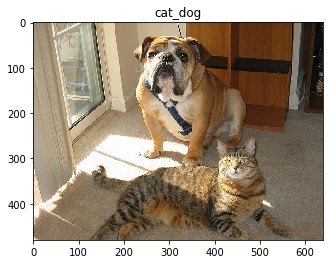

In [3]:
cat_dog = Image.open('/Users/yang/PycharmProjects/grad-cam/images/cat_dog.jpg')
%matplotlib inline
import matplotlib.pyplot as plt 
plt.imshow(cat_dog)
plt.axis('on') # 关掉坐标轴为 off
plt.title('cat_dog') # 图像题目
plt.show()


# cat_dog = (np.array(cat_dog)/255.).astype(np.float32)
# torchvision.io.read_image('/Users/yang/PycharmProjects/grad-cam/images/cat_dog.jpg')
# cat_dog.transpose(2,0,1).shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


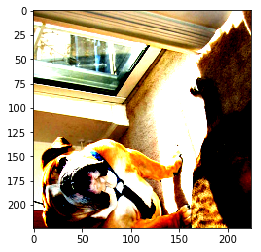

In [4]:
transform = transforms.Compose([
 transforms.RandomResizedCrop(224),
 transforms.RandomHorizontalFlip(),
 transforms.ToTensor(), # 将图片转换为Tensor,归一化至[0,1]
 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
output_softmax = nn.Softmax(dim=1)
cat_dog_ten = transform(cat_dog).unsqueeze(0)

cat_dog_ten.shape
plt.imshow(cat_dog_ten.squeeze().transpose(2,0))


In [5]:
vgg_19.eval()
loss = nn.CrossEntropyLoss()

x = cat_dog_ten
for i in range(50):
    x = vgg_19.features[i](x)
    
conv_out = Variable(x.clone(), requires_grad=True)

x = vgg_19.features[50](conv_out)
x = vgg_19.features[51](x)
x = vgg_19.features[52](x)

# conv_out = Variable(x.clone(), requires_grad=True)


x = vgg_19.avgpool(x)
x = torch.flatten(x, 1)
output = vgg_19.classifier(x)

# output = vgg_19(cat_dog_ten)

In [6]:
outsoft = output_softmax(output)
outsoft.shape
print(torch.max(output, dim=1)[0])
vgg_19.zero_grad()
# conv_out.zero_grad()

torch.max(output, dim=1)[0].backward(retain_graph=True)

tensor([14.5282], grad_fn=<MaxBackward0>)


In [7]:
conv_out_grad = conv_out.grad
print(conv_out_grad)

tensor([[[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ..., -0.0400,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0760,  0.0000,  0.0000,  ...,  0.0075,  0.0000,  0.0352],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0206,  0.0000,  0.0000],
          ...,
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0284],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0003,  0.0032,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  

In [8]:
# def forward(self, x):
#     x = self.features(x)
#     x = self.avgpool(x)
#     x = torch.flatten(x, 1)
#     x = self.classifier(x)
#     return x

# vgg_19.zero_grad()
conv_out_grad_weight = conv_out_grad.sum(dim=(2,3), keepdim=True)
conv_out_grad_mul_weight = conv_out_grad * conv_out_grad_weight

Max and min is tensor(0.0059) tensor(0.0006)


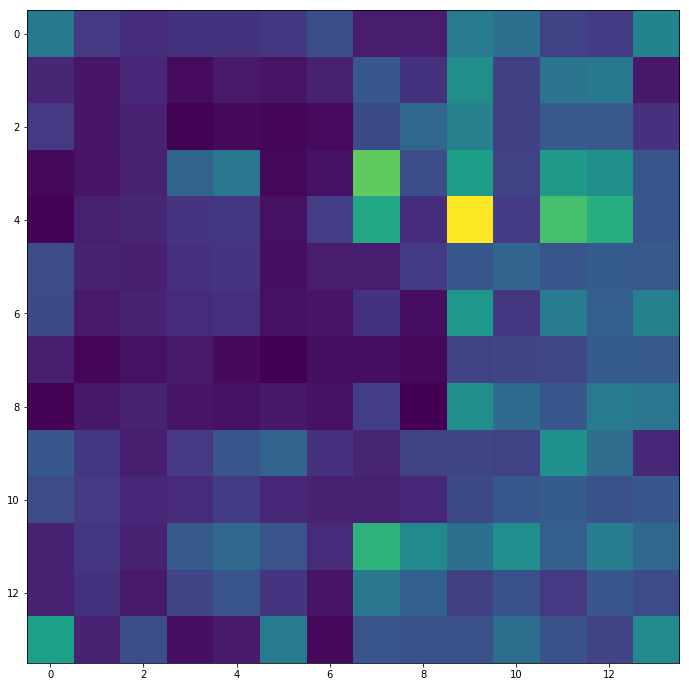

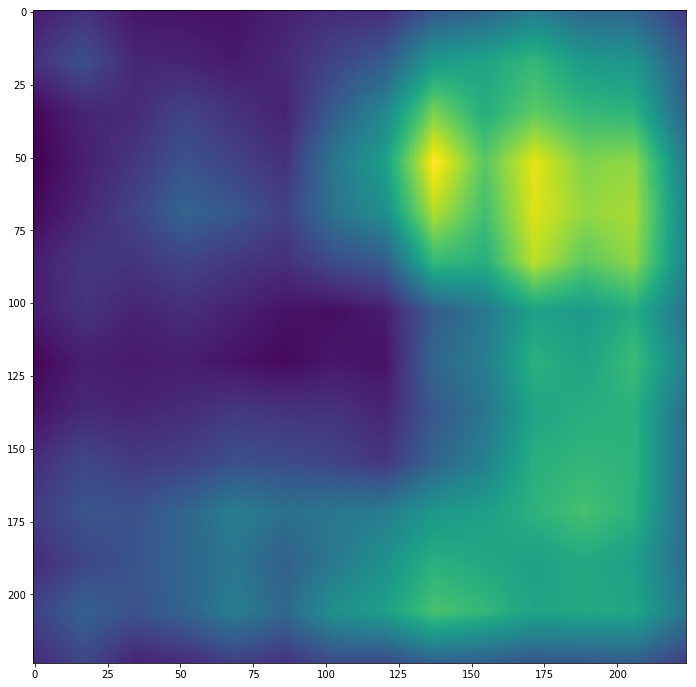

In [19]:
# vgg_19.features
avg_pool = nn.AvgPool2d(kernel_size=(3,3), stride=1, padding=1)

conv_out_grad_gap_relu = torch.nn.functional.relu(conv_out_grad_mul_weight.mean(dim=1, keepdim=True))
# conv_out_grad_gap_relu_avg = avg_pool(conv_out_grad_gap_relu)

plt.figure(figsize=(12,12))
plt.imshow(conv_out_grad_gap_relu.squeeze().numpy())

upsample = nn.UpsamplingBilinear2d(size=(224,224))
conv_out_grad_gap_relu_up = upsample(conv_out_grad_gap_relu_avg)

plt.figure(figsize=(12,12))
plt.imshow(conv_out_grad_gap_relu_up.squeeze().numpy())
print('Max and min is', conv_out_grad_gap_relu_up.max(), conv_out_grad_gap_relu_up.min())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


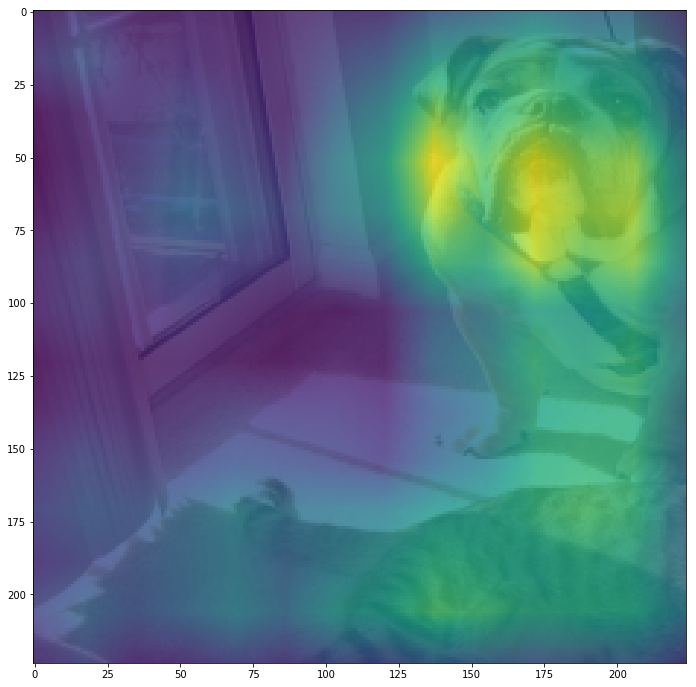

In [29]:
plt.figure(figsize=(12,12))
plt.imshow((cat_dog_ten.squeeze().transpose(2,0).transpose(0,1)+1.8439)/(2.6400+1.8439))

plt.imshow((conv_out_grad_gap_relu_up.squeeze().numpy()-0.0006) /0.0053, alpha=0.8)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Max and min is  tensor(2.6400) tensor(-1.8439)


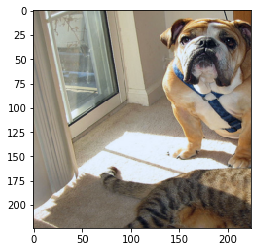

In [27]:
plt.imshow((cat_dog_ten.squeeze().transpose(2,0).transpose(0,1)+1.8439)/(2.6400+1.8439))

print('Max and min is ', cat_dog_ten.squeeze().max(), cat_dog_ten.squeeze().min())